# LSTM on Economic data

# Basic LSTM
<img src='image/data.png' width=70% height=70% />

Data source: https://fred.stlouisfed.org/series/S4248SM144NCEN

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Load the dataset

In [ ]:
df = pd.read_csv('data/data.csv',index_col=0,parse_dates=True)
len(df)

In [7]:
df.head()+df.tail()

,S4248SM144NCEN
DATE,
1992-01-01,NaN
1992-02-01,NaN
1992-03-01,NaN
1992-04-01,NaN
1992-05-01,NaN
2020-05-01,NaN
2020-06-01,NaN
2020-07-01,NaN
2020-08-01,NaN


## Plotting time series data

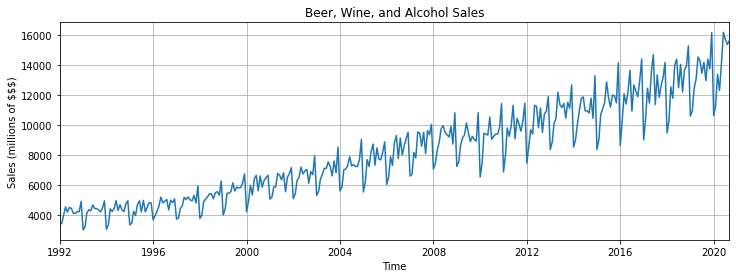

In [8]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.xlabel('Time')
plt.ylabel('Sales (millions of $$$)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

## Prepare the data
In the next steps we'll divide the data into train/test sets, then normalize the training values so that they fall between -1 and 1 (to improve training). We'll train the model, then predict into a period that matches the test set. Finally, we'll forecast into an unknown future.

In [9]:
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [10]:
test_set

array([14427., 13773., 16197., 10659., 11350., 13410., 12334., 14111.,
       16215., 15757., 15400., 15644.])

## Normalize the data

We can use scikit-learn to do this, with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'><tt><strong>sklearn.preprocessing.MinMaxScaler()</strong></tt></a>

In [23]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [24]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [25]:
train_norm.min()

-1.0

In [26]:
train_norm.max()

1.0

In [27]:
train_norm.mean()

-0.18902139086223163

In [28]:
type(train_norm)

numpy.ndarray

## Prepare data for LSTM
We create our list of (seq/label) tuples from the training set. 

In [29]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 325-12-12

321

In [31]:
# Display the first seq/label tuple in the train data
train_data[-1]

(tensor([0.4987, 0.7424, 0.7786, 1.0000, 0.2356, 0.2943, 0.5380, 0.6400, 0.8803,
         0.8320, 0.7029, 0.8203]),
 tensor([0.6227]))

## Define the model

In [32]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

In [34]:
torch.manual_seed(101)
model = LSTMnetwork()
model

# move tensors to GPU if CUDA is available
#if train_on_gpu:
#    model.cuda()

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [37]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


## Define loss and optimization functions

In [38]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the model

In [39]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00133734
Epoch:  2 Loss: 0.00055909
Epoch:  3 Loss: 0.00088352
Epoch:  4 Loss: 0.00340863
Epoch:  5 Loss: 0.00272515
Epoch:  6 Loss: 0.00334154
Epoch:  7 Loss: 0.00316053
Epoch:  8 Loss: 0.00349070
Epoch:  9 Loss: 0.00522094
Epoch: 10 Loss: 0.00576956
Epoch: 11 Loss: 0.00658436
Epoch: 12 Loss: 0.00381551
Epoch: 13 Loss: 0.00310680
Epoch: 14 Loss: 0.00087665
Epoch: 15 Loss: 0.00083905
Epoch: 16 Loss: 0.00012224
Epoch: 17 Loss: 0.00004187
Epoch: 18 Loss: 0.01021964
Epoch: 19 Loss: 0.02151727
Epoch: 20 Loss: 0.00802593
Epoch: 21 Loss: 0.01065865
Epoch: 22 Loss: 0.00333429
Epoch: 23 Loss: 0.00036104
Epoch: 24 Loss: 0.00063126
Epoch: 25 Loss: 0.01063911
Epoch: 26 Loss: 0.00029900
Epoch: 27 Loss: 0.00001800
Epoch: 28 Loss: 0.00000141
Epoch: 29 Loss: 0.00000002
Epoch: 30 Loss: 0.00055614
Epoch: 31 Loss: 0.00002453
Epoch: 32 Loss: 0.00195631
Epoch: 33 Loss: 0.00234351
Epoch: 34 Loss: 0.00192932
Epoch: 35 Loss: 0.00237989
Epoch: 36 Loss: 0.00656060
Epoch: 37 Loss: 0.01404870
E

## Run predictions and compare to known data

In [40]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [41]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.8689180016517639,
 0.9998487234115601,
 0.8602192401885986,
 0.4789503216743469,
 0.4663569927215576,
 0.615219235420227,
 0.7141125202178955,
 0.7900701761245728,
 0.6549487709999084,
 0.6342025399208069,
 0.6026965975761414,
 0.674737811088562]

## Invert the normalization
We want to compare our test predictions to the original data, so we need to undo the previous normalization step. Note that <tt>inverse_transform</tt> uses the most recently applied parameters; we can rescale based on the test data, but not on the previous training data.

In [42]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[14503.35315314],
       [15307.07138866],
       [14449.9558059 ],
       [12109.5365496 ],
       [12032.23239982],
       [12946.02327663],
       [13553.07970536],
       [14019.34577614],
       [13189.90303078],
       [13062.5522913 ],
       [12869.15306422],
       [13311.37805337]])

In [43]:
df['S4248SM144NCEN'][-12:]

DATE
2019-10-01    14427
2019-11-01    13773
2019-12-01    16197
2020-01-01    10659
2020-02-01    11350
2020-03-01    13410
2020-04-01    12334
2020-05-01    14111
2020-06-01    16215
2020-07-01    15757
2020-08-01    15400
2020-09-01    15644
Name: S4248SM144NCEN, dtype: int64

## Plot the results

In [53]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-09-01', '2020-09-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
       '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
       '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01'],
      dtype='datetime64[D]')

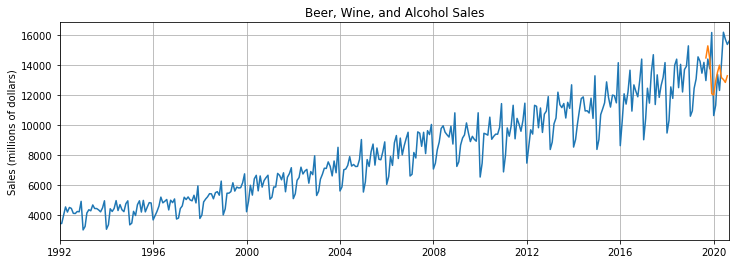

In [54]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

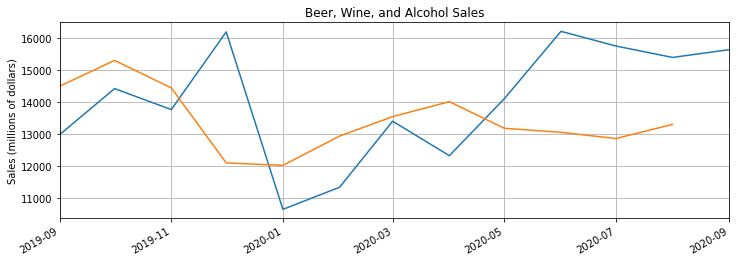

In [55]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2019-09-01':])
plt.plot(x,true_predictions)
plt.show()